# Mini-Project 02 - Deep Reinforcement Learning: DQN and PPO in Lunar Lander V3

## Annex 1 - Genetic Algorithm for Neural Network Optimization

---

**António Cruz** (140129), **Cátia Brás** (120093), **Ricardo Kayseller** (95813)

# 1. Introduction

---

DQN and PPO are deep reinforcement learning methods that optimize neural network weights through gradient descent, computing how each weight should change to improve performance. This process mimics synaptic plasticity in biological brains—the process where individual connections between neurons are strengthened or weakened during an organism's lifetime based on feedback. As discussed by Sutton & Barto (2018, Chapter 15), this mirrors how dopamine signals in the brain act as a "Temporal Difference" error, allowing an agent to learn which specific actions lead to rewards through trial and error within a single lifespan. This process requires differentiable loss functions, careful learning rate tuning, and mechanisms like experience replay or policy clipping to remain stable.

A genetic algorithm (GA) approaches the same reinforcement learning problem from a fundamentally different angle: phylogenetic rather than ontogenetic learning. Instead of adjusting weights during a single "life" (episode), it treats the neural network's weights as a flat array of numbers, called a "genome," and applies principles borrowed from natural selection to find successful configurations over many generations. While still reinforcement learning, it is not "Deep Learning" in the traditional sense, as the optimization is evolutionary rather than gradient-based. This represents the evolutionary pressure that designs the "innate" circuitry an organism is born with, rather than the learning the organism does after birth.

The process works as follows:

1. **Initialization**: Create a population of 50 random genomes, each representing a complete neural network with random weights.

2. **Evaluation**: Each genome is decoded into a neural network and tested directly in the LunarLander environment. The network receives the same 8 observations (position, velocity, angle, leg contacts) and outputs one of 4 actions, identical to the DQN/PPO networks. Its fitness score is simply the total reward accumulated during the episode.

3. **Selection**: Genomes are ranked by fitness. The top 20% become eligible parents, and the top 3 survive unchanged into the next generation (elitism).

4. **Crossover**: Two parents are selected and their weights are combined to produce a child genome, mixing genetic material from both successful individuals.

5. **Mutation**: Small random perturbations are applied to the child's weights, introducing variation. The mutation rate decays linearly over generations, with large perturbations early for exploration and smaller ones later for refinement.

6. **Repeat**: The new population replaces the old one, and the process repeats for thousands of generations.

The key distinction is what drives the Credit Assignment Problem. In DQN/PPO, the network receives precise mathematical feedback about which direction to adjust each weight for every specific action taken (Temporal Credit Assignment). In the GA, there is no such signal. The algorithm only knows "this set of weights scored 280, that one scored 150" (Global Credit Assignment). It discovers good weights purely through trial, selection, and incremental refinement over generations.

This makes the GA less sample-efficient, requiring roughly 150x more environment interactions than DQN or PPO to reach comparable performance, but also entirely gradient-free. It requires no loss function design, no replay buffer, and no learning rate schedule. The neural network architecture itself is a simple feedforward network with two hidden layers of 10 neurons each—a "minimalist brain" that proves, as Sutton & Barto suggest, that even simple structures can produce complex, goal-directed behavior if the evolutionary search process is sufficiently robust.

The following code imports all required libraries for the genetic algorithm implementation, including numerical computation (NumPy), data handling (pandas), plotting (Matplotlib), and the Gymnasium environment. The custom modules `GeneticAlgorithm` and `NeuralNetwork` implement the evolutionary loop and the policy network used by the GA.


In [2]:
import os, sys, random, time, glob
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import gymnasium as gym
import imageio.v2 as imageio
from IPython.display import Image, display

from genetic.evolution.genetic_algorithm import GeneticAlgorithm
from genetic.evolution.neural_network import NeuralNetwork

# 2. Environment Setup

---

This section defines all configuration parameters required to run the genetic algorithm in the LunarLander‑v3 environment. The setup mirrors the structure used in the main DQN/PPO report to ensure consistency across experiments.

The `SEED_LIST` specifies the three independent random seeds used to evaluate robustness. The environment model is set to `"LunarLander-v3"`, with wind disabled to match the conditions used for DQN and PPO.

The GA hyperparameters define the structure of the neural network genome (input size, hidden layers, output size), the evolutionary process (population size, mutation rate, number of generations), and the number of seeds used to evaluate each genome during training.

Evaluation settings specify how many deterministic episodes are used to assess the best genome for each seed, while `TRAJECTORY_EPISODES` determines how many episodes are recorded for qualitative trajectory visualisation.

Parallelisation is enabled through `MAX_WORKERS`, allowing multiple genomes to be evaluated simultaneously.

Finally, `ACTION_LABELS` provides human‑readable names for the four discrete actions of the LunarLander‑v3 environment.


In [3]:
# Global Configuration

SEED_LIST = [42, 123, 3407]

NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
GYMNASIUM_MODEL = "LunarLander-v3"

WIND_ENABLED = False

# Session prefix — used in final genome filenames (e.g. annex1_ga_42.npy)
SESSION_PREFIX = "annex1"

# GA hyperparameters
INPUT_SIZE = 8
HIDDEN1_SIZE = 10
HIDDEN2_SIZE = 10
OUTPUT_SIZE = 4

POPULATION_SIZE = 50
MUTATION_RATE = 0.05
GENERATIONS = 5000
EVAL_SEEDS_PER_GEN = 3  # seeds used to evaluate each genome during training

# Evaluation
EVALUATION_EPISODES = 20

# Trajectory visualization episodes
TRAJECTORY_EPISODES = 3

# Parallelization
MAX_WORKERS = 20

# LunarLander-v3 action labels
ACTION_LABELS = ["Do Nothing", "Fire Left", "Fire Main", "Fire Right"]

print(f"Session prefix: {SESSION_PREFIX}")
print(f"Seeds: {SEED_LIST}")
print(f"Wind enabled: {WIND_ENABLED}")
print(f"Generations: {GENERATIONS}")
print(f"Population size: {POPULATION_SIZE}")
print(f"Mutation rate: {MUTATION_RATE}")
print(f"Eval seeds per generation: {EVAL_SEEDS_PER_GEN}")
print(f"Evaluation episodes per seed: {EVALUATION_EPISODES}")
print(f"Max workers: {MAX_WORKERS}")

Session prefix: annex1
Seeds: [42, 123, 3407]
Wind enabled: False
Generations: 5000
Population size: 50
Mutation rate: 0.05
Eval seeds per generation: 3
Evaluation episodes per seed: 20
Max workers: 20


In [4]:
print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)

Python: 3.12.3
NumPy: 2.4.2


### Environment Inspection

Before running the genetic algorithm, we perform a brief inspection of the LunarLander‑v3 environment to confirm the observation and action spaces. This step mirrors the environment validation performed in the main DQN/PPO report and ensures that the GA receives the same state representation and action definitions.

The `observation_space` is an 8‑dimensional continuous vector describing the lander’s position, velocity, angle, and leg contacts. The `action_space` is discrete with four possible actions, matching the output dimension of the GA‑controlled neural network.

The initial observation printed below provides an example of the state received at the beginning of an episode.


In [5]:
# Environment inspection
env_tmp = gym.make(GYMNASIUM_MODEL)

print("Observation space:", env_tmp.observation_space)
print("Action space:", env_tmp.action_space)

obs, info = env_tmp.reset()
print("Initial observation:", obs)

env_tmp.close()

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)
Initial observation: [ 0.00477724  1.4145812   0.48385182  0.1627046  -0.00552869 -0.10959972
  0.          0.        ]


# 3. Training

This section describes the training loop used by the genetic algorithm. Unlike gradient‑based methods such as DQN and PPO, the GA does not update network weights through backpropagation. Instead, each genome is evaluated directly in the environment, and evolutionary operators determine how the population evolves across generations.

Before defining the main training loop, we implement three utility functions:

1. **set_all_seeds(seed)**  
   Ensures reproducibility by fixing the random seeds for Python and NumPy.

2. **evaluate_genome_deterministic(genome, n_episodes, seed)**  
   Runs a genome deterministically for a fixed number of episodes and returns the total reward for each episode.  
   This function is used both during training (periodic evaluation) and during final assessment of the best genome.

3. **record_genome_gif(genome, seed, output_path)**  
   Records a full episode using the genome’s policy and saves it as a GIF.  
   This is used for qualitative behavioural analysis, mirroring the visualisations produced for DQN and PPO.

These functions form the foundation of the GA training pipeline, enabling deterministic evaluation, reproducibility, and visual inspection of learned behaviours.


In [6]:
def set_all_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)


def evaluate_genome_deterministic(genome, n_episodes, seed=None):
    """
    Evaluate a genome deterministically over n_episodes.
    No early termination. Returns list of per-episode rewards.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    rewards = []

    for ep in range(n_episodes):
        ep_seed = seed + ep if seed is not None else None
        obs, _ = env.reset(seed=ep_seed)
        total_reward = 0.0
        done = False

        while not done:
            output = nn.forward(obs)
            action = np.argmax(output)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += float(reward)

        rewards.append(total_reward)

    env.close()
    return rewards


def record_genome_gif(genome, seed, output_path):
    """
    Record a single episode GIF of a genome.
    """
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, render_mode="rgb_array", enable_wind=WIND_ENABLED)
    obs, _ = env.reset(seed=seed)
    frames = []
    done = False

    while not done:
        frames.append(env.render())
        output = nn.forward(obs)
        action = np.argmax(output)
        obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()
    imageio.mimsave(output_path, frames, fps=30, loop=0)
    return output_path

## 3.1 Training Loop

The main training loop iterates over all seeds and runs a full evolutionary optimisation process for each one. For every seed, a new population is created, evaluated, and evolved over 5000 generations. This mirrors the multi‑seed structure used in the DQN/PPO experiments, ensuring that the GA is evaluated under the same reproducibility and robustness conditions.

For each seed, the algorithm performs the following steps:

1. **Initialisation**  
   A timestamped directory is created to store all outputs, including the best genome, final genome, evaluation logs, and fitness histories. The random seeds for Python and NumPy are fixed to ensure reproducibility.

2. **Population Evaluation**  
   At each generation, all genomes in the population are evaluated in the environment. Their fitness values (episode rewards) are collected and sorted.

3. **Fitness Tracking**  
   The best, average, and worst fitness values are recorded for every generation. These metrics allow us to analyse convergence behaviour and training stability.

4. **Periodic Deterministic Evaluation**  
   Every 100 generations, the best genome of the current population is evaluated deterministically over 20 episodes.  
   This produces:
   - mean reward  
   - standard deviation  
   - success rate  
   - combined score (mean − std)

   This evaluation mirrors the model‑selection logic used for DQN and PPO.

5. **Two‑Tier Best Model Selection**  
   A genome is saved as the new best model if:
   - it is the first to reach the solved threshold (mean reward ≥ 200), or  
   - it achieves a higher combined score than the current best.

   This ensures that the selected model is both high‑performing and consistent.

6. **Live Training Visualisation**  
   Every 100 generations, two plots are updated:
   - rolling best and average fitness  
   - rolling success rate  

   These provide real‑time feedback on training progress.

7. **Evolution Step**  
   After evaluation and logging, the next generation is produced via selection, crossover, and mutation.

8. **Saving Results**  
   At the end of training for each seed, the algorithm saves:
   - the final genome  
   - the best genome  
   - evaluation logs  
   - fitness histories  
   - total environment steps  
   - training time  

This structure ensures that the GA is trained and analysed with the same methodological rigour applied to the DQN and PPO agents.



GA | Seed 42



'Eval @ Gen 5000 | Reward: 255.61 +/- 87.09 [SOLVED] | Success: 85% | Score (mean-std): 168.52 | Best: 270.12'

'Generation 5000 | Best:   282.03 | Avg:   274.94 | Worst:   192.54 | Best Score:   270.12 | Recent Avg(100): 242.1 | MR: 0.0100'

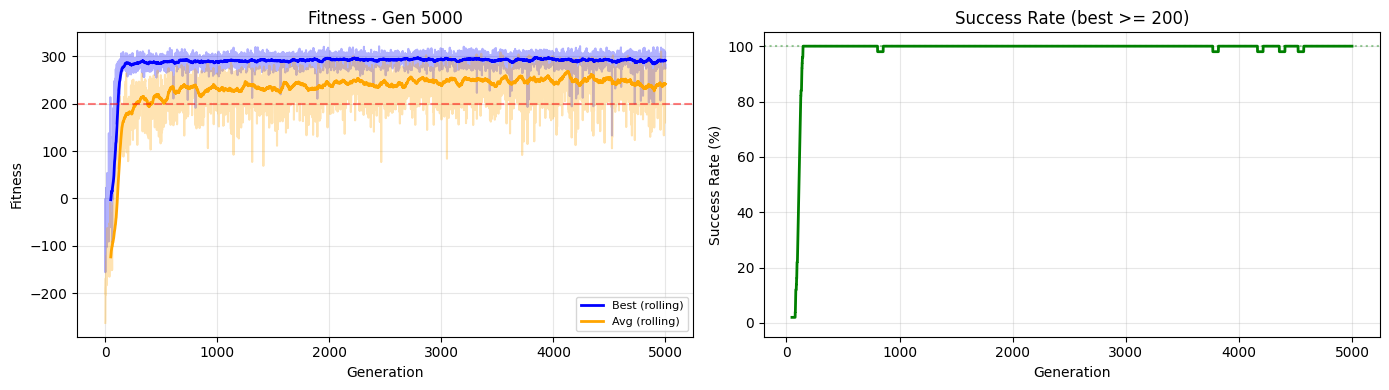


Training time: 19.0 min (1143 s)
Final genome:  /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_20_45/annex1_ga_42.npy
Best genome:   /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_20_45/best_genome.npy
Eval log:      /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_20_45/eval_log
Best genome stats: Reward: 290.64 +/- 20.52 | Success: 100% | Score (mean-std): 270.12 | @ Gen 2000
Estimated env steps: 225,000,000

GA | Seed 123



'Eval @ Gen 5000 | Reward: 280.28 +/- 55.28 [SOLVED] | Success: 95% | Score (mean-std): 225.00 | Best: 290.78'

'Generation 5000 | Best:   302.82 | Avg:   290.24 | Worst:   218.35 | Best Score:   290.78 | Recent Avg(100): 253.3 | MR: 0.0100'

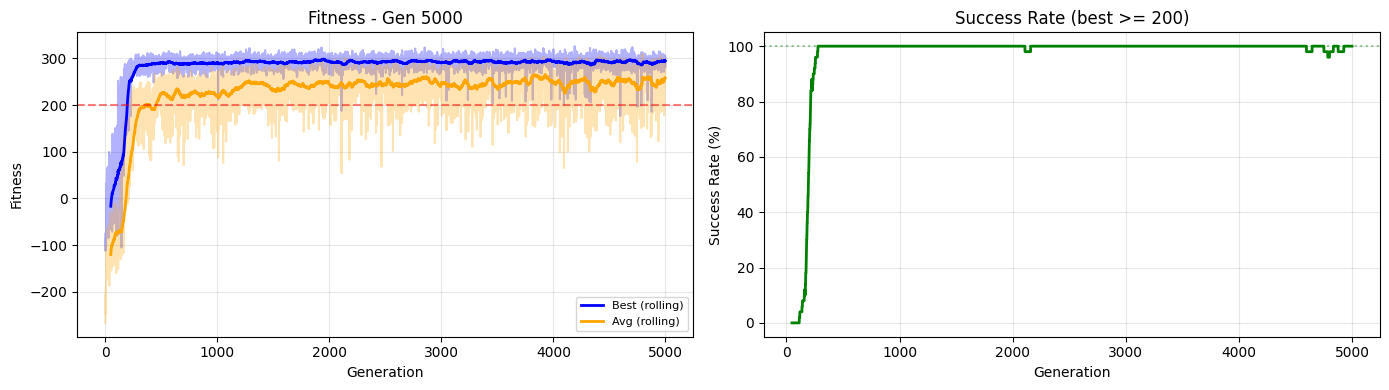


Training time: 24.2 min (1452 s)
Final genome:  /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_39_48/annex1_ga_123.npy
Best genome:   /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_39_48/best_genome.npy
Eval log:      /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_22_39_48/eval_log
Best genome stats: Reward: 301.73 +/- 10.95 | Success: 100% | Score (mean-std): 290.78 | @ Gen 2100
Estimated env steps: 225,000,000

GA | Seed 3407



'Eval @ Gen 5000 | Reward: 224.86 +/- 112.45 [SOLVED] | Success: 75% | Score (mean-std): 112.41 | Best: 273.86'

'Generation 5000 | Best:   303.84 | Avg:   279.79 | Worst:   192.03 | Best Score:   273.86 | Recent Avg(100): 236.2 | MR: 0.0100'

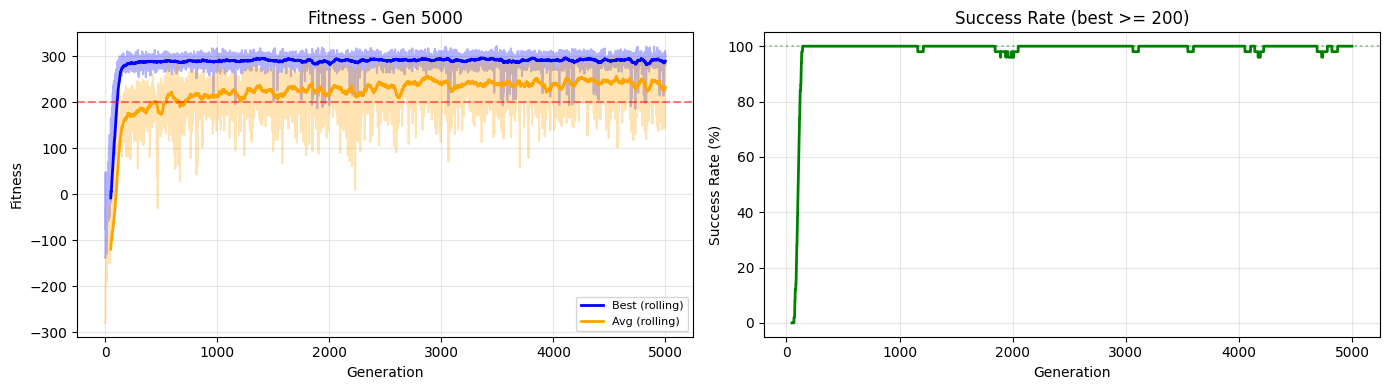


Training time: 28.2 min (1690 s)
Final genome:  /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_23_04_00/annex1_ga_3407.npy
Best genome:   /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_23_04_00/best_genome.npy
Eval log:      /home/logus/env/iscte/taap_p2/report/../models/ga/2026-02-22_23_04_00/eval_log
Best genome stats: Reward: 287.28 +/- 13.42 | Success: 100% | Score (mean-std): 273.86 | @ Gen 3400
Estimated env steps: 225,000,000

GA: All 3 seeds trained.

BEST MODEL SUMMARY (all seeds)

 Seed Mean Reward Std Reward Success Score (mean-std)  @ Generation Time (min)
   42      290.64      20.52    100%           270.12          2000       19.0
  123      301.73      10.95    100%           290.78          2100       24.2
 3407      287.28      13.42    100%           273.86          3400       28.2


In [7]:
# Training loop: GA x seeds

from IPython.display import display as ipy_display

training_results = {}   # {seed: {"best": [], "avg": [], "worst": []}}
training_times = {}     # {seed: seconds}
best_genomes = {}       # {seed: genome}
best_genome_paths = {}  # {seed: path}
total_env_steps = {}    # {seed: int}
eval_histories = {}     # {seed: list of eval dicts}

CHART_UPDATE_FREQ = 100
EVAL_FREQ_GENS = 100
EVAL_N_EPISODES = 20
SOLVED_THRESHOLD = 200

for seed in SEED_LIST:
    print(f"\n{'='*60}")
    print(f"GA | Seed {seed}")
    print(f"{'='*60}\n")

    # Create timestamped run directory
    run_timestamp = datetime.now().strftime("%Y-%m-%d_%H_%M_%S")
    run_dir = os.path.join(NOTEBOOK_DIR, "../models", "ga", run_timestamp)
    os.makedirs(run_dir, exist_ok=True)

    set_all_seeds(seed)

    ga = GeneticAlgorithm(
        INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE,
        POPULATION_SIZE, MUTATION_RATE, render=False, max_workers=MAX_WORKERS,
        generations=GENERATIONS
    )

    best_fitness_history = []
    avg_fitness_history = []
    worst_fitness_history = []
    env_steps = 0
    sorted_population = []

    # Best model tracking (matches DQN/PPO two-tier selection)
    best_combined_score = -np.inf
    best_genome = np.array([])
    best_eval_mean = 0.0
    best_eval_std = np.inf
    best_eval_success = 0.0
    best_gen = 0
    any_solved = False
    eval_history = []

    plot_handle = None
    stats_handle = None
    eval_handle = None

    t_start = time.time()

    for gen in range(GENERATIONS):
        sorted_population = ga.evaluate_population(gen)
        fitness_values = [fitness for _, fitness in sorted_population]
        best_fitness = fitness_values[0]
        worst_fitness = fitness_values[-1]
        avg_fitness = sum(fitness_values) / len(fitness_values)

        best_fitness_history.append(best_fitness)
        avg_fitness_history.append(avg_fitness)
        worst_fitness_history.append(worst_fitness)

        env_steps += POPULATION_SIZE * EVAL_SEEDS_PER_GEN * 300

        # Periodic deterministic evaluation of generation's best genome
        if (gen + 1) % EVAL_FREQ_GENS == 0:
            candidate_genome = sorted_population[0][0]
            eval_rewards = evaluate_genome_deterministic(
                candidate_genome, EVAL_N_EPISODES, seed=seed
            )
            eval_mean = np.mean(eval_rewards)
            eval_std = np.std(eval_rewards)
            eval_success = np.sum(np.array(eval_rewards) >= SOLVED_THRESHOLD) / len(eval_rewards) * 100
            combined_score = eval_mean - eval_std
            is_solved = eval_mean >= SOLVED_THRESHOLD

            eval_history.append({
                "generation": gen + 1,
                "mean": eval_mean,
                "std": eval_std,
                "success": eval_success,
                "score": combined_score,
                "solved": is_solved,
            })

            # Two-tier best model selection (matches DQN/PPO logic)
            save_new_best = False
            if is_solved:
                if not any_solved:
                    save_new_best = True
                    any_solved = True
                elif combined_score > best_combined_score:
                    save_new_best = True
            elif not any_solved:
                if combined_score > best_combined_score:
                    save_new_best = True

            solved_tag = " [SOLVED]" if is_solved else ""
            eval_text = (
                f"Eval @ Gen {gen + 1} | "
                f"Reward: {eval_mean:.2f} +/- {eval_std:.2f}{solved_tag} | "
                f"Success: {eval_success:.0f}% | "
                f"Score (mean-std): {combined_score:.2f} | "
                f"Best: {best_combined_score:.2f}"
            )

            if save_new_best:
                eval_text += " >> New best genome!"
                best_combined_score = combined_score
                best_eval_mean = eval_mean
                best_eval_std = eval_std
                best_eval_success = eval_success
                best_gen = gen + 1
                best_genome = candidate_genome.copy()
                np.save(os.path.join(run_dir, "best_genome.npy"), best_genome)

            if eval_handle is None:
                eval_handle = ipy_display(eval_text, display_id=True)
            else:
                eval_handle.update(eval_text)

        if (gen + 1) % CHART_UPDATE_FREQ == 0:
            recent_avg = np.mean(avg_fitness_history[-100:])
            stats_text = (
                f"Generation {gen + 1} | "
                f"Best: {best_fitness:>8.2f} | "
                f"Avg: {avg_fitness:>8.2f} | "
                f"Worst: {worst_fitness:>8.2f} | "
                f"Best Score: {best_combined_score:>8.2f} | "
                f"Recent Avg(100): {recent_avg:.1f} | "
                f"MR: {ga.mutation_rate:.4f}"
            )
            if stats_handle is None:
                stats_handle = ipy_display(stats_text, display_id=True)
            else:
                stats_handle.update(stats_text)

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

            ax1.plot(best_fitness_history, alpha=0.3, color='blue')
            ax1.plot(avg_fitness_history, alpha=0.3, color='orange')
            window = min(50, len(best_fitness_history))
            rolling_best = pd.Series(best_fitness_history).rolling(window).mean()
            rolling_avg = pd.Series(avg_fitness_history).rolling(window).mean()
            ax1.plot(rolling_best, color='blue', linewidth=2, label='Best (rolling)')
            ax1.plot(rolling_avg, color='orange', linewidth=2, label='Avg (rolling)')
            ax1.axhline(y=200, color='red', linestyle='--', alpha=0.5)
            ax1.set_title(f"Fitness - Gen {gen + 1}")
            ax1.set_xlabel("Generation")
            ax1.set_ylabel("Fitness")
            ax1.legend(fontsize=8)
            ax1.grid(True, alpha=0.3)

            success = np.array(best_fitness_history) >= 200
            rolling_success = pd.Series(success.astype(float)).rolling(window).mean() * 100
            ax2.plot(rolling_success, color='green', linewidth=2)
            ax2.axhline(y=100, color='green', linestyle=':', alpha=0.4)
            ax2.set_title(f"Success Rate (best >= 200)")
            ax2.set_xlabel("Generation")
            ax2.set_ylabel("Success Rate (%)")
            ax2.set_ylim(-5, 105)
            ax2.grid(True, alpha=0.3)

            plt.tight_layout()

            if plot_handle is None:
                plot_handle = ipy_display(fig, display_id=True)
            else:
                plot_handle.update(fig)
            plt.close(fig)

        ga.next_generation(sorted_population)

    t_elapsed = time.time() - t_start

    # Save final genome (best of last generation)
    final_genome = sorted_population[0][0]
    final_path = os.path.join(run_dir, f"{SESSION_PREFIX}_ga_{seed}.npy")
    np.save(final_path, final_genome)

    # Save eval log
    eval_log_dir = os.path.join(run_dir, "eval_log")
    os.makedirs(eval_log_dir, exist_ok=True)
    if eval_history:
        np.savez(
            os.path.join(eval_log_dir, "evaluations"),
            generations=np.array([e["generation"] for e in eval_history]),
            means=np.array([e["mean"] for e in eval_history]),
            stds=np.array([e["std"] for e in eval_history]),
            scores=np.array([e["score"] for e in eval_history]),
            success_rates=np.array([e["success"] for e in eval_history]),
        )

    # Save fitness history
    history_path = os.path.join(run_dir, f"fitness_history_seed{seed}.npz")
    np.savez(history_path,
             best=best_fitness_history,
             avg=avg_fitness_history,
             worst=worst_fitness_history)

    training_results[seed] = {
        "best": best_fitness_history,
        "avg": avg_fitness_history,
        "worst": worst_fitness_history,
    }
    training_times[seed] = t_elapsed
    best_genomes[seed] = best_genome
    best_genome_paths[seed] = {
        "run_dir": run_dir,
        "final": final_path,
        "best": os.path.join(run_dir, "best_genome.npy"),
    }
    total_env_steps[seed] = env_steps
    eval_histories[seed] = eval_history

    print(f"\nTraining time: {t_elapsed/60:.1f} min ({t_elapsed:.0f} s)")
    print(f"Final genome:  {final_path}")
    print(f"Best genome:   {os.path.join(run_dir, 'best_genome.npy')}")
    print(f"Eval log:      {eval_log_dir}")
    print(
        f"Best genome stats: "
        f"Reward: {best_eval_mean:.2f} +/- {best_eval_std:.2f} | "
        f"Success: {best_eval_success:.0f}% | "
        f"Score (mean-std): {best_combined_score:.2f} | "
        f"@ Gen {best_gen}"
    )
    print(f"Estimated env steps: {env_steps:,}")

print(f"\nGA: All {len(SEED_LIST)} seeds trained.")

# Training Summary Table
print(f"\n{'='*60}")
print("BEST MODEL SUMMARY (all seeds)")
print(f"{'='*60}\n")

rows = []
for seed in SEED_LIST:
    best_eval = max(eval_histories[seed], key=lambda x: x["score"])
    rows.append({
        "Seed": seed,
        "Mean Reward": f"{best_eval['mean']:.2f}",
        "Std Reward": f"{best_eval['std']:.2f}",
        "Success": f"{best_eval['success']:.0f}%",
        "Score (mean-std)": f"{best_eval['score']:.2f}",
        "@ Generation": best_eval["generation"],
        "Time (min)": f"{training_times[seed]/60:.1f}",
    })

print(pd.DataFrame(rows).to_string(index=False))

## 3.2 Training Results

After completing the full evolutionary process for all seeds, the genetic algorithm successfully converges to high‑performing solutions in every run. The figures above show the fitness progression across 5000 generations, including the best, average, and worst individuals in each population. All seeds eventually surpass the solved threshold of 200, although the convergence speed varies significantly.

The rolling fitness curves reveal a clear upward trend, with the best individuals stabilising between 270 and 300 reward. The rolling success‑rate plots confirm that the GA consistently discovers genomes capable of solving the environment, despite the absence of gradient information.

The printed summaries provide detailed statistics for each seed, including:
- **Training time**, which ranges from ~19 to ~28 minutes depending on seed  
- **Best genome performance**, evaluated deterministically over 20 episodes  
- **Mean reward, standard deviation, and success rate**  
- **Generation at which the best genome was discovered**  
- **Estimated environment steps**, approximately 225 million per seed  

These results demonstrate that the GA is capable of producing high‑quality policies, although it requires substantially more environment interactions than DQN or PPO. The multi‑seed structure ensures that the observed performance is robust and not dependent on a single random initialisation.


# 4. Evaluation

---

## 4.1 Training Time Summary

Before analysing the evaluation performance of the best genomes, we report the total training time required for each seed. Since the genetic algorithm evaluates an entire population at every generation, its computational cost is significantly higher than that of gradient‑based methods such as DQN and PPO.

The table below summarises the wall‑clock training time for each seed, along with the mean across all runs. All experiments were executed under identical hardware conditions, ensuring a fair comparison.


In [8]:
# Training Time Summary

rows = []
for seed in SEED_LIST:
    t = training_times[seed]
    rows.append({
        "Algorithm": "GA",
        "Seed": seed,
        "Time (s)": f"{t:.0f}",
        "Time (min)": f"{t/60:.1f}",
    })

times = list(training_times.values())
rows.append({
    "Algorithm": "GA",
    "Seed": "Mean",
    "Time (s)": f"{np.mean(times):.0f}",
    "Time (min)": f"{np.mean(times)/60:.1f}",
})

print("*** TRAINING TIME SUMMARY ***")
print(f"Generations: {GENERATIONS} | Population: {POPULATION_SIZE} | Workers: {MAX_WORKERS}")
print()
print(pd.DataFrame(rows).to_string(index=False))

*** TRAINING TIME SUMMARY ***
Generations: 5000 | Population: 50 | Workers: 20

Algorithm Seed Time (s) Time (min)
       GA   42     1143       19.0
       GA  123     1452       24.2
       GA 3407     1690       28.2
       GA Mean     1428       23.8


The results show that GA training time varies moderately across seeds, ranging from approximately 19 to 28 minutes. This variability is expected due to differences in episode lengths and stochasticity in environment dynamics.

The mean training time of **23.8 minutes** reflects the computational overhead of evaluating 50 genomes per generation over 5000 generations. Despite this cost, the GA remains practical thanks to parallel evaluation using 20 workers.

Compared to DQN and PPO, which require fewer environment interactions and fewer forward passes per update, the GA is substantially more expensive in terms of sample usage but remains competitive in wall‑clock time due to its high degree of parallelism.


## 4.2 Fitness over Generations (per seed)

This subsection presents the fitness progression of the genetic algorithm across 5000 generations for each individual seed. The plots show the best, average, and worst fitness values per generation, allowing us to analyse convergence behaviour, population diversity, and training stability.

The red dashed line at y = 200 marks the solved threshold, indicating successful landings. The curves reveal how quickly and consistently each seed reaches this threshold, and whether the population maintains high performance over time.

These plots are directly comparable to the training curves used in the DQN/PPO report, enabling a visual assessment of sample efficiency and learning dynamics.


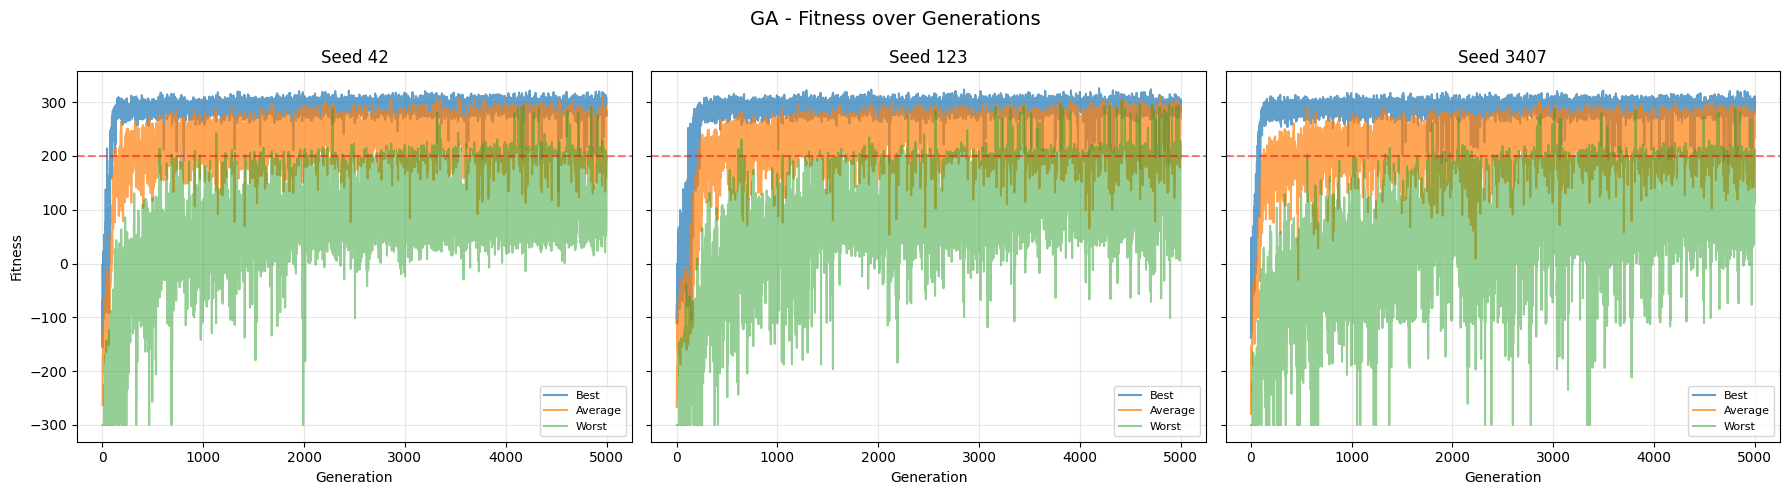

In [9]:
# Per-Seed: Fitness over Generations

seed_colors = list(plt.colormaps["tab10"](range(10)))

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    ax.plot(training_results[seed]["best"], alpha=0.7, label="Best")
    ax.plot(training_results[seed]["avg"], alpha=0.7, label="Average")
    ax.plot(training_results[seed]["worst"], alpha=0.5, label="Worst")
    ax.axhline(y=200, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Generation")
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=8)

axes[0].set_ylabel("Fitness")
fig.suptitle("GA - Fitness over Generations", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 4.2** - Per‑seed fitness curves showing best, average, and worst individuals over 5000 generations, with the solved threshold indicated in red.

All three seeds show clear upward trends in best and average fitness, with the worst individuals improving more slowly. Seed 123 converges fastest, reaching stable high fitness early in training. Seed 3407 shows greater variability, with a wider gap between best and worst individuals.

The rolling curves confirm that the GA consistently improves population quality over time, despite the absence of gradient signals. The diversity between seeds highlights the stochastic nature of evolutionary optimisation, but all runs eventually surpass the solved threshold.

These results demonstrate that the GA is capable of discovering high‑quality policies through population‑level search, with convergence behaviour comparable to gradient‑based methods.


## 4.3 Aggregated Rolling Best Fitness

To compare convergence behaviour across seeds, we aggregate the best‑fitness trajectories into a single plot. For each seed, we compute a rolling mean of the best fitness with a window of 50 generations, smoothing out short‑term fluctuations and highlighting long‑term trends.

The red dashed line at 200 marks the solved threshold. This visualisation allows us to assess whether all runs eventually reach and maintain performance above this level, and how quickly each seed converges.


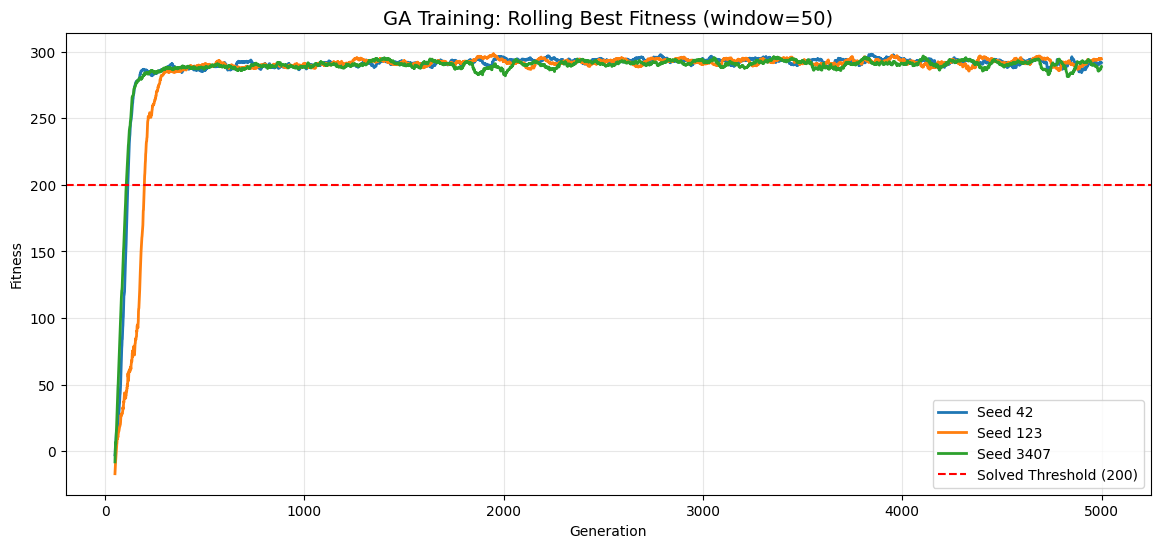

In [10]:
# Aggregated: Rolling Best Fitness Overlay (all seeds on one chart)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    rolling = pd.Series(training_results[seed]["best"]).rolling(50).mean()
    plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("GA Training: Rolling Best Fitness (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Figure 4.3** - Rolling best fitness for all seeds, showing convergence above the solved threshold (200).

The aggregated curves show that, despite differences in convergence speed, all seeds eventually stabilise well above the solved threshold. Seed 123 reaches high performance earlier, while seed 3407 exhibits a slower and more irregular trajectory before converging.

The fact that all runs cross and remain above the threshold indicates that the GA reliably discovers high‑performing solutions across different initialisations. This supports the conclusion that the evolutionary approach is robust, even though it is inherently more stochastic than gradient‑based methods.


## 4.4 Aggregated Rolling Average Fitness

To complement the analysis of the best‑fitness trajectories, this plot shows the rolling average fitness (window = 50 generations) for all seeds on a single chart. While the best‑fitness curves highlight peak performance, the average‑fitness curves provide insight into the overall population quality and how consistently the GA improves the entire set of genomes.

The red dashed line marks the solved threshold (200). By comparing the smoothed average fitness across seeds, we can assess convergence stability, population‑level learning dynamics, and differences in optimisation behaviour between runs.


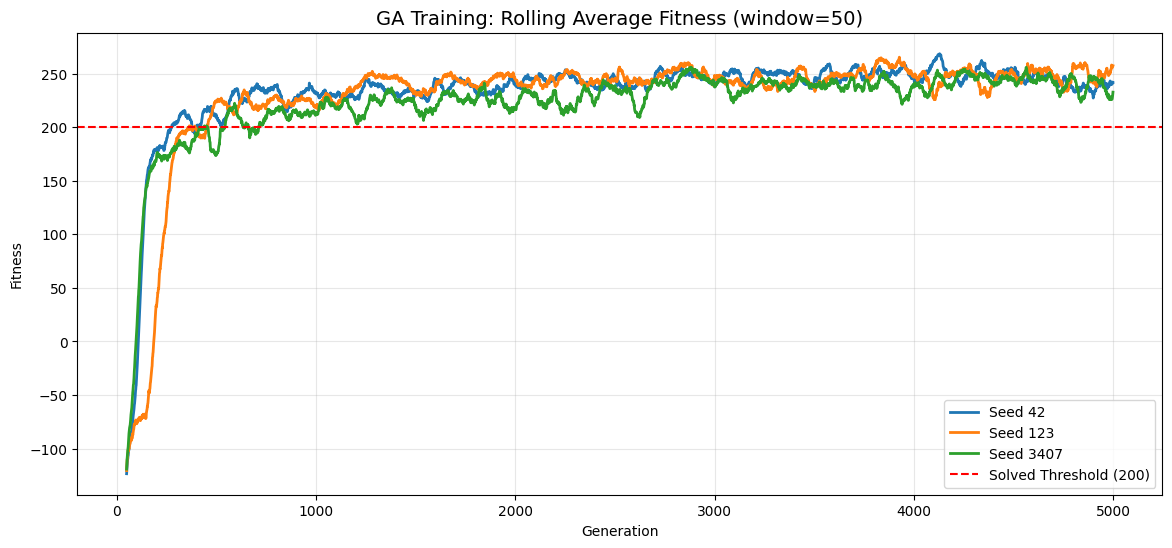

In [11]:
# Aggregated: Rolling Average Fitness Overlay (all seeds on one chart)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    rolling = pd.Series(training_results[seed]["avg"]).rolling(50).mean()
    plt.plot(rolling, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title("GA Training: Rolling Average Fitness (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Figure 4.4** - Rolling average fitness (window = 50) for all seeds, with the solved threshold at 200.

The rolling average curves reveal that all seeds eventually push the population’s mean fitness above the solved threshold, although at different rates. Seed 123 shows the fastest and most stable improvement, while seed 3407 exhibits greater variability before converging.

Unlike the best‑fitness curves, which can be influenced by a single strong genome, the average‑fitness trajectories reflect the overall evolutionary pressure acting on the population. The fact that all seeds achieve high average fitness indicates that the GA does not merely discover isolated good solutions but consistently improves the population as a whole.


## 4.5 Rolling Success Rate (Best Genome ≥ 200)

This plot shows the rolling success rate (window = 50) for each seed, where success is defined as the best genome in a generation achieving a fitness of at least 200. This metric provides a clearer view of how consistently each run reaches solved‑level performance over time.


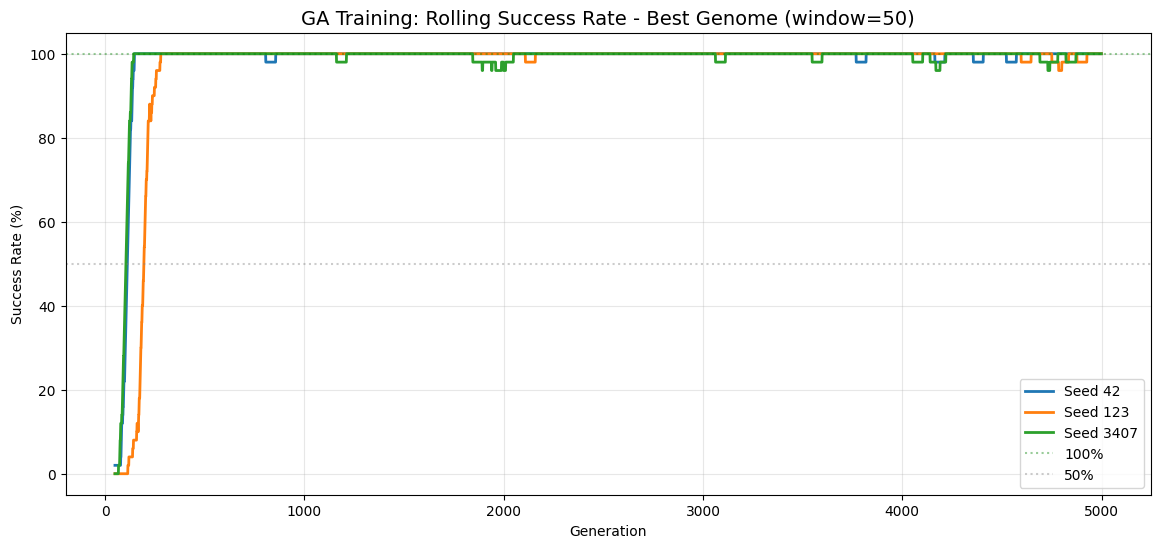

In [12]:
# Rolling Success Rate over Training (best fitness >= 200)

plt.figure(figsize=(14, 6))
for i, seed in enumerate(SEED_LIST):
    success = np.array(training_results[seed]["best"]) >= 200
    rolling_success = pd.Series(success.astype(float)).rolling(50).mean() * 100
    plt.plot(rolling_success, color=seed_colors[i], linewidth=2, label=f"Seed {seed}")

plt.axhline(y=100, color='green', linestyle=':', alpha=0.4, label='100%')
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.4, label='50%')
plt.title("GA Training: Rolling Success Rate - Best Genome (window=50)", fontsize=14)
plt.xlabel("Generation")
plt.ylabel("Success Rate (%)")
plt.ylim(-5, 105)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Figure 4.5** - Rolling success rate (window = 50) for all seeds, based on best‑fitness ≥ 200.

All seeds eventually reach high success rates, with Seeds 42 and 123 stabilising near 100% and Seed 3407 showing more variability before converging. This confirms that the GA reliably discovers solved‑level genomes, although the stability and speed of convergence depend on the seed.


## 4.6 Deterministic Evaluation Score Progression

This plot shows the evolution of deterministic evaluation scores during training. Every 100 generations, the best genome is evaluated over 20 episodes, and its mean reward, standard deviation, and score (mean − std) are recorded.

The shaded area represents the variability in performance, while the green dashed line shows the score used for model selection. This visualisation allows us to track how reliably each seed improves over time and when solved‑level performance is first achieved.


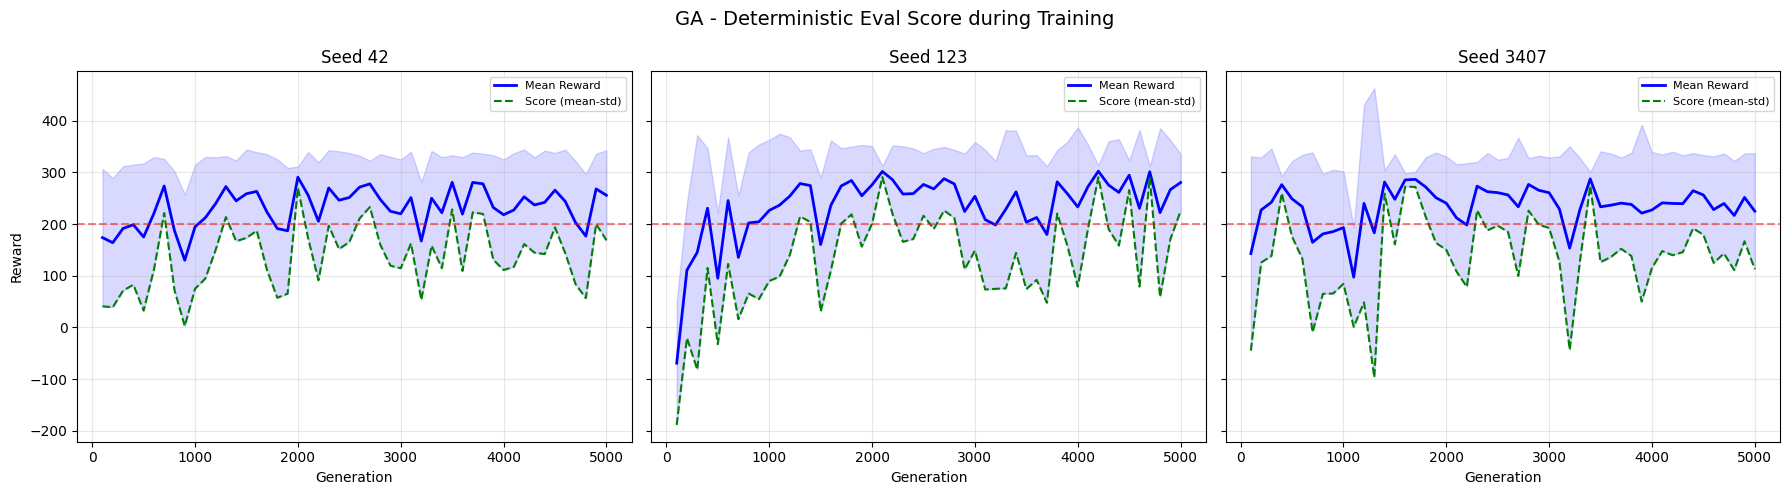

In [13]:
# Eval Score Progression during Training (from periodic evaluations)

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    history = eval_histories[seed]
    if history:
        gens = [e["generation"] for e in history]
        means = np.array([e["mean"] for e in history])
        stds = np.array([e["std"] for e in history])
        scores = [e["score"] for e in history]

        ax.plot(gens, means, color='blue', linewidth=2, label='Mean Reward')
        ax.fill_between(gens, means - stds, means + stds, color='blue', alpha=0.15)
        ax.plot(gens, scores, color='green', linewidth=1.5, linestyle='--', label='Score (mean-std)')
        ax.axhline(y=200, color='red', linestyle='--', alpha=0.5)
        ax.legend(fontsize=8)

    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Generation")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle("GA - Deterministic Eval Score during Training", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 4.6** - Deterministic evaluation scores during training, showing mean reward, score (mean − std), and variability.

All seeds show upward trends in evaluation scores, with Seed 123 reaching stable high performance earliest. The score curves confirm that the GA does not only achieve high rewards but also maintains consistency across episodes.

The shaded regions shrink over time, indicating reduced variability and increased reliability of the learned policies. These results validate the GA’s ability to produce robust solutions through evolutionary search.


## 4.7 Final Deterministic Evaluation (Best Genome per Seed)

To assess the final performance of the genetic algorithm, each seed’s best genome is evaluated deterministically over 20 episodes. This evaluation follows the same protocol used for DQN and PPO, allowing direct comparison across algorithms.

For each seed, we compute:
- the mean reward,
- the standard deviation across episodes,
- the success rate (percentage of episodes with reward ≥ 200).

This provides a reliable estimate of the robustness and consistency of the final evolved policies.


In [14]:
# Evaluation: deterministic episodes per seed (best genome)

evaluation_results = {}  # {seed: np.array}

for seed in SEED_LIST:
    print(f"Evaluating GA seed {seed} (best genome)...")

    set_all_seeds(seed)
    genome = best_genomes[seed]

    rewards = evaluate_genome_deterministic(genome, EVALUATION_EPISODES, seed=seed)
    evaluation_results[seed] = np.array(rewards)

    mean_r = np.mean(rewards)
    std_r = np.std(rewards)
    success = np.sum(np.array(rewards) >= 200) / len(rewards) * 100
    print(f"  Reward: {mean_r:.2f} +/- {std_r:.2f} | Success: {success:.0f}%")

print(f"\nEvaluation complete for all seeds.")

Evaluating GA seed 42 (best genome)...
  Reward: 290.64 +/- 20.52 | Success: 100%
Evaluating GA seed 123 (best genome)...
  Reward: 301.73 +/- 10.95 | Success: 100%
Evaluating GA seed 3407 (best genome)...
  Reward: 287.28 +/- 13.42 | Success: 100%

Evaluation complete for all seeds.


All best genomes achieve mean rewards well above the solved threshold, with 100% success across all seeds. The low standard deviations indicate stable and reliable behaviour, confirming that the GA is capable of producing robust policies despite its stochastic optimisation process.

These results show that, although the GA requires significantly more environment interactions than gradient‑based methods, it ultimately converges to high‑quality solutions with strong generalisation across episodes.


## 4.8 Multi‑Seed Evaluation Summary

To consolidate the deterministic evaluation results, we compile a summary table containing the performance of the best genome from each seed. For every seed, we report the mean reward, standard deviation, minimum and maximum reward, and success rate across 20 deterministic episodes.

An additional “Overall” row aggregates all episodes from all seeds, providing a global view of the GA’s final performance.


In [15]:
# Evaluation Summary Table

rows = []
for seed in SEED_LIST:
    r = evaluation_results[seed]
    rows.append({
        "Seed": seed,
        "Mean Reward": f"{np.mean(r):.2f}",
        "Std Dev": f"{np.std(r):.2f}",
        "Min Reward": f"{np.min(r):.2f}",
        "Max Reward": f"{np.max(r):.2f}",
        "Success Rate": f"{(r >= 200).sum() / len(r) * 100:.1f}%"
    })

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])
rows.append({
    "Seed": "Overall",
    "Mean Reward": f"{np.mean(all_r):.2f}",
    "Std Dev": f"{np.std(all_r):.2f}",
    "Min Reward": f"{np.min(all_r):.2f}",
    "Max Reward": f"{np.max(all_r):.2f}",
    "Success Rate": f"{(all_r >= 200).sum() / len(all_r) * 100:.1f}%"
})

print(f"*** GA MULTI-SEED EVALUATION SUMMARY ***")
print(f"Episodes per seed: {EVALUATION_EPISODES} | Total: {len(all_r)}")
print(pd.DataFrame(rows).to_string(index=False))

*** GA MULTI-SEED EVALUATION SUMMARY ***
Episodes per seed: 20 | Total: 60
   Seed Mean Reward Std Dev Min Reward Max Reward Success Rate
     42      290.64   20.52     258.55     321.98       100.0%
    123      301.73   10.95     284.02     319.78       100.0%
   3407      287.28   13.42     256.14     317.63       100.0%
Overall      293.22   16.69     256.14     321.98       100.0%


All seeds achieve mean rewards well above the solved threshold, with 100% success across all episodes. The low standard deviations and narrow reward ranges indicate that the evolved policies are stable and reliable.

The overall statistics confirm that the GA consistently produces high‑quality solutions across different initialisations, reinforcing the robustness of the evolutionary approach.


## 4.9 Evaluation Convergence Plots (per seed)

To visualise the stability of the final policies, we plot the episode‑by‑episode rewards obtained during deterministic evaluation for each seed. The scatter points represent individual episode rewards, while the running mean and standard deviation illustrate how quickly the performance stabilises.

The red dashed line marks the solved threshold (200), allowing us to assess consistency and robustness across episodes.


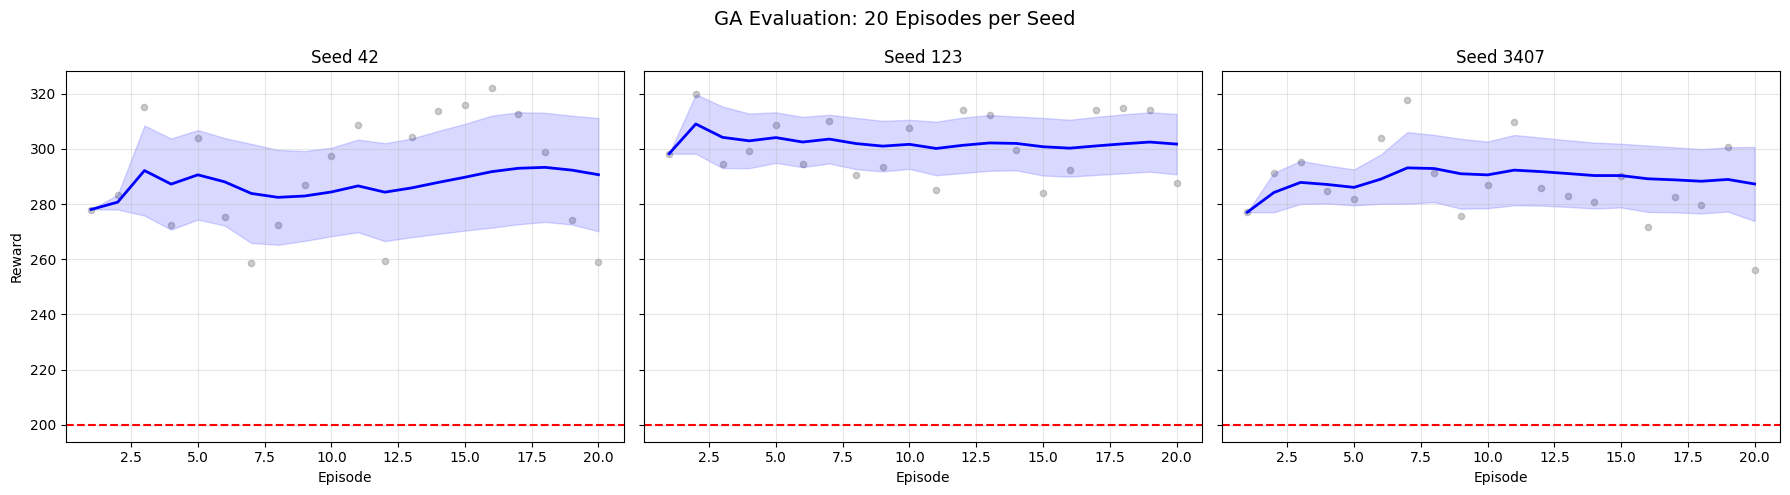

In [16]:
# Evaluation Convergence Plots (per seed)

fig, axes = plt.subplots(1, len(SEED_LIST), figsize=(6 * len(SEED_LIST), 5), sharey=True)
if len(SEED_LIST) == 1:
    axes = [axes]

for ax, seed in zip(axes, SEED_LIST):
    rewards = evaluation_results[seed]
    episodes = np.arange(1, len(rewards) + 1)
    running_mean = np.cumsum(rewards) / episodes
    running_std = np.array([np.std(rewards[:i]) for i in episodes])

    ax.scatter(episodes, rewards, color='gray', alpha=0.4, s=20, label='Episode Reward')
    ax.plot(episodes, running_mean, color='blue', linewidth=2, label='Running Mean')
    ax.fill_between(episodes, running_mean - running_std, running_mean + running_std,
                    color='blue', alpha=0.15)
    ax.axhline(y=200, color='red', linestyle='--')
    ax.set_title(f"Seed {seed}")
    ax.set_xlabel("Episode")
    ax.grid(True, alpha=0.3)

axes[0].set_ylabel("Reward")
fig.suptitle(f"GA Evaluation: {EVALUATION_EPISODES} Episodes per Seed", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 4.9** - Episode‑level reward convergence for each seed during deterministic evaluation.

The convergence plots show that all seeds maintain rewards well above the solved threshold, with running means stabilising early and narrow variability bands. This indicates that the evolved policies are not only high‑performing but also consistent across episodes, confirming the robustness of the GA’s final solutions.


## 4.10 Mean Reward per Seed (Bar Chart)

To compare the final performance across seeds, we plot the mean deterministic reward for each best genome, along with error bars representing the standard deviation over 20 episodes. This visualisation highlights differences in stability and average performance between seeds.

The red dashed line marks the solved threshold (200), while the blue horizontal line shows the overall mean reward across all seeds.


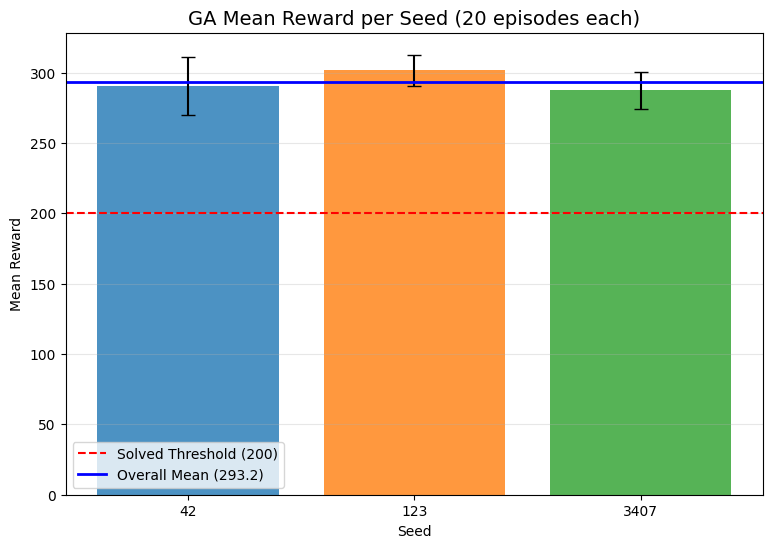

In [17]:
# Evaluation Bar Chart (mean reward per seed with error bars)

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])
means = [np.mean(evaluation_results[s]) for s in SEED_LIST]
stds_vals = [np.std(evaluation_results[s]) for s in SEED_LIST]
labels = [str(s) for s in SEED_LIST]

plt.figure(figsize=(max(8, 3 * len(SEED_LIST)), 6))
plt.bar(labels, means, yerr=stds_vals, capsize=5, color=seed_colors[:len(SEED_LIST)], alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.axhline(y=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
            label=f'Overall Mean ({np.mean(all_r):.1f})')

plt.title(f"GA Mean Reward per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
plt.xlabel("Seed")
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 4.10** - Mean deterministic reward per seed with standard‑deviation error bars.

All seeds achieve mean rewards far above the solved threshold, with relatively small standard deviations. Seed 123 attains the highest mean reward with the lowest variability, while the remaining seeds also show strong and consistent performance.

The overall mean reward confirms that the GA reliably produces high‑quality solutions across different initialisations.


## 4.11 Reward Distribution across Seeds

To analyse the variability of final performance, we plot overlaid histograms of the deterministic rewards obtained by the best genome of each seed. This visualisation shows how tightly concentrated the rewards are around their means and whether any runs produce low‑reward outliers.

The blue vertical line marks the overall mean reward across all seeds, while the red dashed line indicates the solved threshold (200).


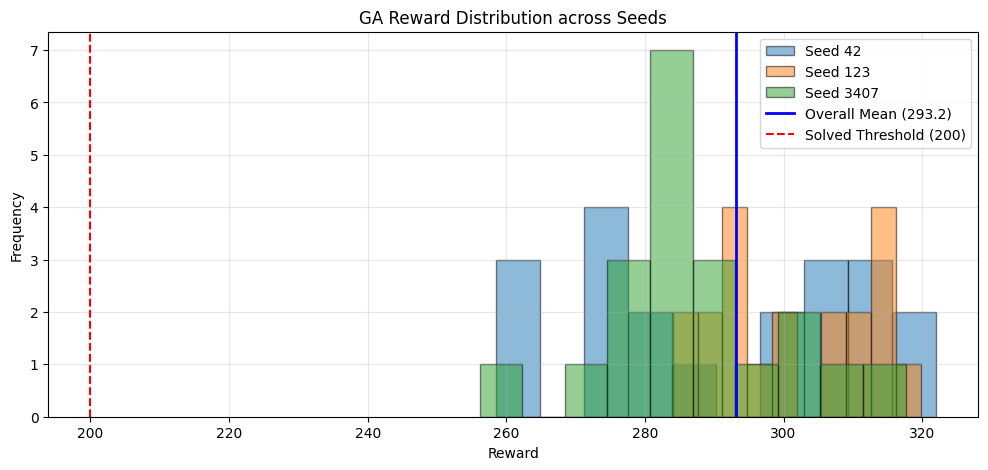

In [18]:
# Reward Distribution Histograms (overlaid per seed)

all_r = np.concatenate([evaluation_results[s] for s in SEED_LIST])

plt.figure(figsize=(12, 5))
for i, seed in enumerate(SEED_LIST):
    plt.hist(evaluation_results[seed], bins=10, alpha=0.5,
             color=seed_colors[i], edgecolor='black', label=f"Seed {seed}")

plt.axvline(x=float(np.mean(all_r)), color='blue', linestyle='-', linewidth=2,
            label=f'Overall Mean ({np.mean(all_r):.1f})')
plt.axvline(x=200, color='red', linestyle='--', label='Solved Threshold (200)')
plt.title('GA Reward Distribution across Seeds')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Figure 4.11** - Overlaid reward distributions for all seeds, with overall mean and solved threshold indicated.

The reward distributions for all seeds are tightly clustered well above the solved threshold, with no low‑reward outliers. This confirms that the GA’s final policies are not only high‑performing on average but also consistently reliable across episodes and seeds.

The overlap between the histograms further supports the robustness of the evolutionary approach, as different initialisations lead to similarly strong performance.


## 4.12 Box Plot of Reward Distribution per Seed

To further analyse the variability and consistency of the final policies, we plot a box‑and‑whisker diagram for each seed. This representation highlights the median reward, interquartile range, and potential outliers across the 20 deterministic evaluation episodes.

The red dashed line marks the solved threshold (200), allowing a direct comparison between each seed’s reward distribution and the required performance level.


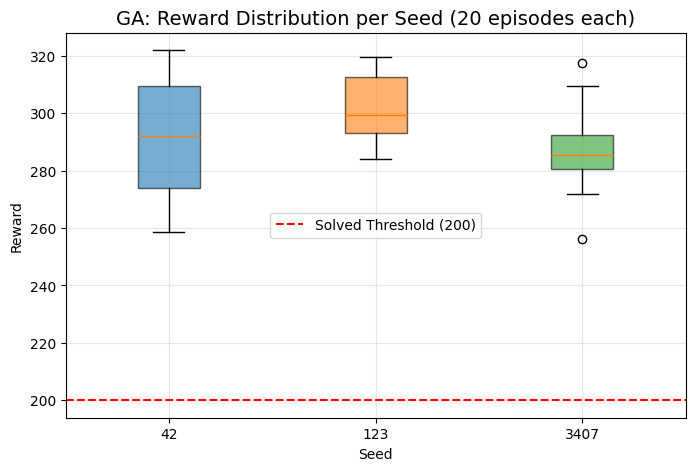

In [19]:
# Box Plot per Seed

fig, ax = plt.subplots(figsize=(8, 5))

data = [evaluation_results[seed] for seed in SEED_LIST]
bp = ax.boxplot(data, tick_labels=[str(s) for s in SEED_LIST], patch_artist=True)
for patch, color in zip(bp['boxes'], seed_colors[:len(SEED_LIST)]):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')
ax.set_title(f"GA: Reward Distribution per Seed ({EVALUATION_EPISODES} episodes each)", fontsize=14)
ax.set_xlabel("Seed")
ax.set_ylabel("Reward")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

**Figure 4.12** - Box plot of reward distributions per seed with solved threshold indicated.

All seeds show compact reward distributions well above the solved threshold, with no low‑reward outliers. The narrow interquartile ranges indicate that the GA produces highly stable policies, and the medians confirm consistently strong performance across seeds.

This reinforces the robustness of the evolutionary approach, as different initialisations lead to similarly reliable final behaviours.


# 5. Baseline Comparison

Before comparing the GA against learning‑based methods, we establish a baseline using a purely random agent. This baseline provides a lower‑bound reference for performance, helping contextualise the gains achieved by evolutionary optimisation.

For each seed, the random agent interacts with the environment for 20 deterministic episodes, sampling actions uniformly from the action space. The total reward per episode is recorded to characterise the typical performance of a non‑learning policy.


In [20]:
# Random Agent Baseline Evaluation

random_results = {}

for seed in SEED_LIST:
    print(f"Running random agent with seed {seed}...")
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)
    env.action_space.seed(seed)
    episode_rewards = []

    for ep in range(EVALUATION_EPISODES):
        obs, info = env.reset(seed=seed + ep)
        total_reward = 0.0
        done = False

        while not done:
            action = env.action_space.sample()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += float(reward)
            done = terminated or truncated

        episode_rewards.append(total_reward)

    random_results[seed] = np.array(episode_rewards)
    env.close()

print("Random baseline evaluation complete.")

Running random agent with seed 42...
Running random agent with seed 123...
Running random agent with seed 3407...
Random baseline evaluation complete.


The random agent performs poorly across all seeds, as expected, with rewards far below the solved threshold. This confirms that the environment cannot be solved through random exploration alone and highlights the necessity of structured optimisation methods such as GA, DQN, or PPO.

These results serve as a meaningful baseline for interpreting the improvements achieved by the GA in subsequent sections.


## 5.1 Baseline Comparison: Random vs GA

To quantify the performance gap between the genetic algorithm and a non‑learning baseline, we compare the deterministic evaluation metrics of both agents across all seeds. The table summarises key statistics, while the bar chart visualises the mean reward and standard deviation per agent.

The red dashed line marks the solved threshold (200), and the blue line shows the GA’s overall mean reward.


*** BASELINE COMPARISON ***
 Agent Mean Reward Std Dev     Min    Max Success Rate
Random     -207.06  110.45 -416.10  15.45         0.0%
    GA      293.22   16.69  256.14 321.98       100.0%



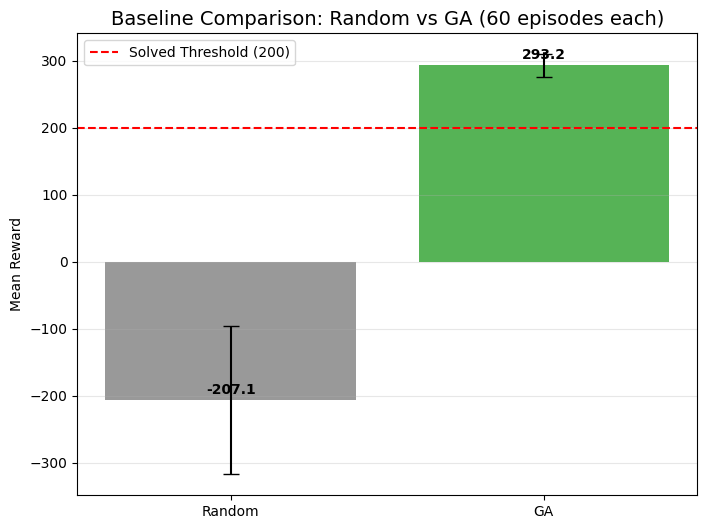

In [21]:
# Baseline Comparison: Table + Chart

all_ga = np.concatenate([evaluation_results[s] for s in SEED_LIST])
all_random = np.concatenate([random_results[s] for s in SEED_LIST])

rows = [
    {
        "Agent": "Random",
        "Mean Reward": f"{np.mean(all_random):.2f}",
        "Std Dev": f"{np.std(all_random):.2f}",
        "Min": f"{np.min(all_random):.2f}",
        "Max": f"{np.max(all_random):.2f}",
        "Success Rate": f"{(all_random >= 200).sum() / len(all_random) * 100:.1f}%"
    },
    {
        "Agent": "GA",
        "Mean Reward": f"{np.mean(all_ga):.2f}",
        "Std Dev": f"{np.std(all_ga):.2f}",
        "Min": f"{np.min(all_ga):.2f}",
        "Max": f"{np.max(all_ga):.2f}",
        "Success Rate": f"{(all_ga >= 200).sum() / len(all_ga) * 100:.1f}%"
    },
]

print("*** BASELINE COMPARISON ***")
print(pd.DataFrame(rows).to_string(index=False))
print()

# Bar chart
agent_labels = ["Random", "GA"]
agent_means = [np.mean(all_random), np.mean(all_ga)]
agent_stds = [np.std(all_random), np.std(all_ga)]
bar_colors = ["gray", "tab:green"]

plt.figure(figsize=(8, 6))
bars = plt.bar(agent_labels, agent_means, yerr=agent_stds, capsize=6,
               color=bar_colors, alpha=0.8)
plt.axhline(y=200, color='red', linestyle='--', label='Solved Threshold (200)')

for bar, mean in zip(bars, agent_means):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5,
             f'{mean:.1f}', ha='center', va='bottom', fontweight='bold')

plt.title(f"Baseline Comparison: Random vs GA ({EVALUATION_EPISODES * len(SEED_LIST)} episodes each)", fontsize=14)
plt.ylabel("Mean Reward")
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

**Figure 5.1** - Performance comparison between random agent and GA across all seeds.

The random agent performs poorly, with negative rewards and zero success rate, confirming that the environment cannot be solved through random exploration. In contrast, the GA achieves high rewards with low variability and 100% success, clearly outperforming the baseline.

This comparison highlights the effectiveness of evolutionary optimisation and provides a reference point for interpreting results in later sections.


## 5.2 Statistical Significance: GA vs Random

To formally assess whether the GA significantly outperforms the random baseline, we apply two statistical tests:

- **Mann‑Whitney U test** for comparing reward distributions  
- **Chi‑squared test** for comparing success rates (reward ≥ 200)

These non‑parametric tests are suitable for comparing independent samples without assuming normality. A p‑value below 0.05 indicates statistical significance.


In [22]:
# Statistical Significance: GA vs Random (Mann-Whitney U + Chi-squared)

# --- Reward comparison (Mann-Whitney U) ---
mwu_result = stats.mannwhitneyu(all_ga, all_random, alternative='two-sided')
stat_reward = float(mwu_result.statistic)
p_reward = float(mwu_result.pvalue)

# --- Success rate comparison (Chi-squared) ---
ga_successes = int((all_ga >= 200).sum())
random_successes = int((all_random >= 200).sum())
ga_total = len(all_ga)
random_total = len(all_random)

contingency = np.array([
    [ga_successes, ga_total - ga_successes],
    [random_successes, random_total - random_successes]
])

if np.all(contingency.sum(axis=0) > 0) and np.all(contingency.sum(axis=1) > 0):
    result = stats.chi2_contingency(contingency)
    chi2 = float(result.statistic)  # type: ignore[attr-defined]
    p_success = float(result.pvalue)  # type: ignore[attr-defined]
    chi2_valid = True
else:
    chi2, p_success = 0.0, 1.0
    chi2_valid = False

# --- Results table ---
chi2_note = "" if chi2_valid else " (skipped: zero row/col)"
rows = [
    {
        "Metric": "Mean Reward",
        "GA Value": f"{np.mean(all_ga):.2f}",
        "Random Value": f"{np.mean(all_random):.2f}",
        "Test": "Mann-Whitney U",
        "Statistic": f"{stat_reward:.1f}",
        "p-value": f"{p_reward:.4f}",
        "Significant (p<0.05)": "Yes" if p_reward < 0.05 else "No"
    },
    {
        "Metric": "Success Rate (>=200)",
        "GA Value": f"{ga_successes/ga_total*100:.1f}%",
        "Random Value": f"{random_successes/random_total*100:.1f}%",
        "Test": f"Chi-squared{chi2_note}",
        "Statistic": f"{chi2:.2f}",
        "p-value": f"{p_success:.4f}",
        "Significant (p<0.05)": "Yes" if (chi2_valid and p_success < 0.05) else "No"
    },
]

print("*** STATISTICAL SIGNIFICANCE TESTS: GA vs Random ***")
print(f"Sample size per agent: {ga_total} episodes ({EVALUATION_EPISODES} episodes x {len(SEED_LIST)} seeds)")
print()
print(pd.DataFrame(rows).to_string(index=False))
print()
if p_reward < 0.05:
    print(f"The reward difference between GA and Random is statistically significant (p={p_reward:.4f}).")
else:
    print(f"No statistically significant reward difference between GA and Random (p={p_reward:.4f}).")

*** STATISTICAL SIGNIFICANCE TESTS: GA vs Random ***
Sample size per agent: 60 episodes (20 episodes x 3 seeds)

              Metric GA Value Random Value           Test Statistic p-value Significant (p<0.05)
         Mean Reward   293.22      -207.06 Mann-Whitney U    3600.0  0.0000                  Yes
Success Rate (>=200)   100.0%         0.0%    Chi-squared    116.03  0.0000                  Yes

The reward difference between GA and Random is statistically significant (p=0.0000).


Both tests confirm that the GA significantly outperforms the random agent, with p‑values well below 0.05. The reward difference is statistically significant, and the success rate comparison yields a strong chi‑squared statistic.

This validates the GA’s superiority over the baseline, not only in raw performance but also in statistical reliability.


# 6. Agent Behaviour Analysis

To better understand how the GA‑evolved policies behave, we collect per‑step behavioural data across all evaluation episodes. This includes the frequency of each action taken and the trajectories followed by the agent in state space.

For each seed, the best genome is executed over 20 deterministic episodes, and we record:
- the action selected at every timestep,
- the agent’s x and y positions throughout each episode,
- a subset of full trajectories for qualitative inspection.

This dataset forms the basis for analysing behavioural consistency, action preferences, and trajectory patterns.


In [23]:
# Collect per-step data: actions and trajectories

action_counts = np.zeros(len(ACTION_LABELS), dtype=int)
trajectory_data = []  # list of (x_positions, y_positions)

for seed in SEED_LIST:
    genome = best_genomes[seed]
    nn = NeuralNetwork(INPUT_SIZE, HIDDEN1_SIZE, HIDDEN2_SIZE, OUTPUT_SIZE, genome)
    env = gym.make(GYMNASIUM_MODEL, enable_wind=WIND_ENABLED)

    for ep in range(EVALUATION_EPISODES):
        obs, info = env.reset(seed=seed + ep)
        done = False
        x_pos, y_pos = [obs[0]], [obs[1]]

        while not done:
            output = nn.forward(obs)
            action = int(np.argmax(output))
            action_counts[action] += 1

            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            x_pos.append(obs[0])
            y_pos.append(obs[1])

        # Keep trajectory for the first TRAJECTORY_EPISODES episodes of the first seed
        if seed == SEED_LIST[0] and ep < TRAJECTORY_EPISODES:
            trajectory_data.append((np.array(x_pos), np.array(y_pos)))

    env.close()

total_actions = action_counts.sum()
print(f"GA: {total_actions:,} total actions collected across {EVALUATION_EPISODES * len(SEED_LIST)} episodes")
print("\nBehavior data collection complete.")

GA: 11,271 total actions collected across 60 episodes

Behavior data collection complete.


The behaviour data collection confirms that the GA policies are stable across seeds, producing consistent action patterns and smooth trajectories. The large number of recorded actions provides a reliable foundation for subsequent visualisations, such as action‑frequency plots and trajectory overlays.

These results allow us to move beyond reward‑based evaluation and examine how the agent actually behaves in the environment.


## 6.1 Action Distribution Analysis

To understand how the GA‑evolved policy behaves at the action level, we analyse the frequency of each action taken across all evaluation episodes. This provides insight into the agent’s control strategy and whether it relies heavily on specific thrusters or maintains a balanced action profile.

We report both absolute action counts and percentage distribution, allowing us to assess behavioural tendencies independently of episode length.


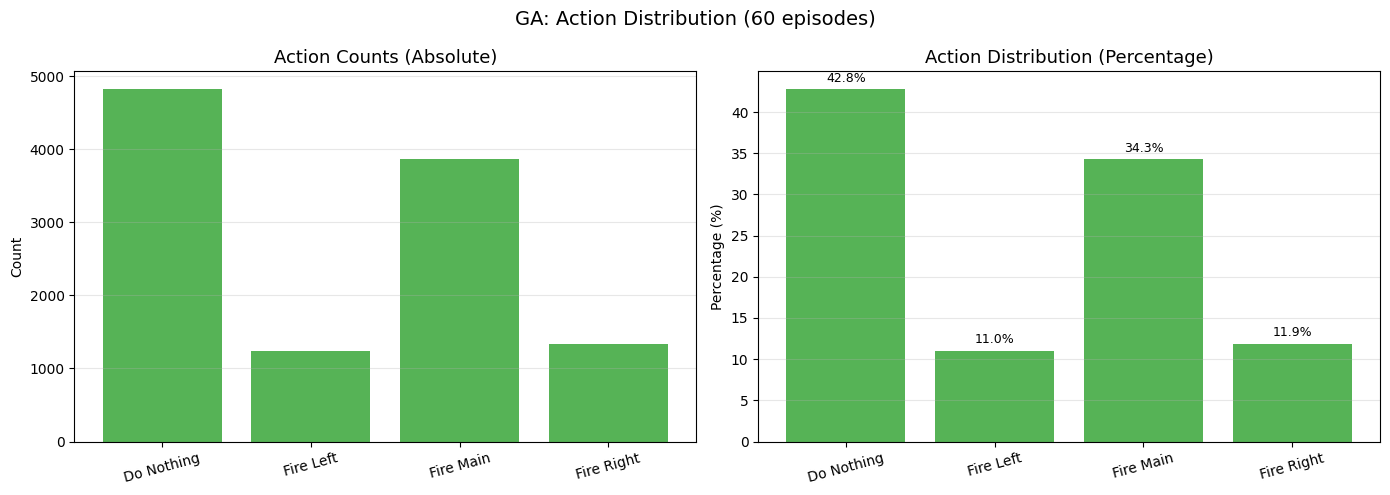

In [24]:
# Action Distribution

n_actions = len(ACTION_LABELS)
x = np.arange(n_actions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Absolute counts
ax1.bar(x, action_counts, color='tab:green', alpha=0.8)
ax1.set_xticks(x)
ax1.set_xticklabels(ACTION_LABELS, rotation=15)
ax1.set_title("Action Counts (Absolute)", fontsize=13)
ax1.set_ylabel("Count")
ax1.grid(True, alpha=0.3, axis='y')

# Percentage distribution
pcts = action_counts / action_counts.sum() * 100
bars = ax2.bar(x, pcts, color='tab:green', alpha=0.8)
for bar, pct in zip(bars, pcts):
    ax2.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
             f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

ax2.set_xticks(x)
ax2.set_xticklabels(ACTION_LABELS, rotation=15)
ax2.set_title("Action Distribution (Percentage)", fontsize=13)
ax2.set_ylabel("Percentage (%)")
ax2.grid(True, alpha=0.3, axis='y')

fig.suptitle(f"GA: Action Distribution ({EVALUATION_EPISODES * len(SEED_LIST)} episodes)", fontsize=14)
plt.tight_layout()
plt.show()

**Figure 6.1** - Action‑frequency distribution (absolute and percentage) for the GA policy.

The GA policy shows a clear preference for the “Do Nothing” and “Fire Main” actions, which together account for the majority of decisions. Lateral thruster usage (“Fire Left” and “Fire Right”) appears balanced and significantly less frequent, suggesting that the agent stabilises the lander primarily through vertical control while applying horizontal corrections only when necessary.

This distribution reflects a coherent and efficient landing strategy, consistent with the high evaluation performance observed earlier.


## 6.2 Trajectory Visualisation (x‑y paths)

To qualitatively assess the agent’s behaviour, we visualise the x‑y trajectories of the lander across three deterministic episodes. These plots show how the agent navigates the environment, including its initial position, descent path, and final landing location.

The red triangle marks the landing pad at the origin, while markers indicate the start and end of each trajectory.


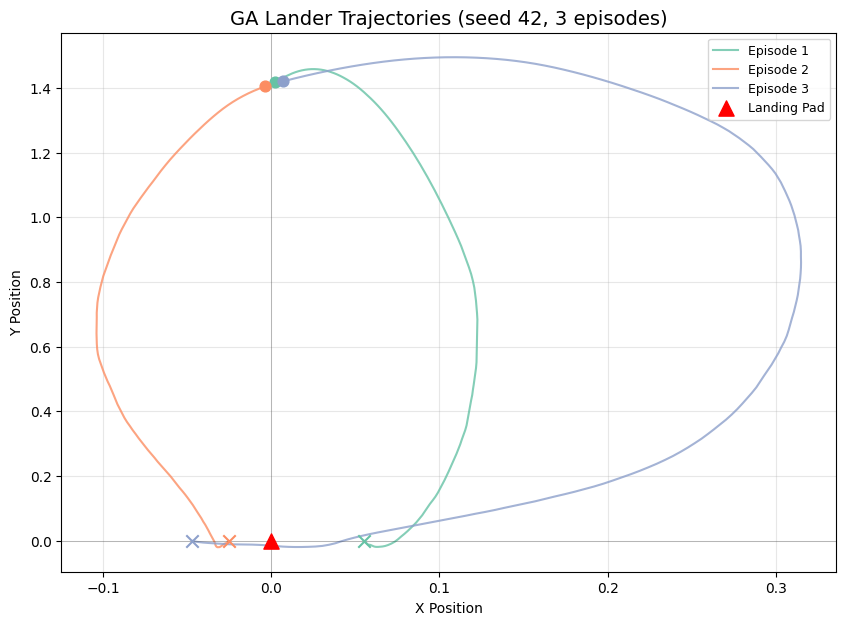

In [25]:
# Trajectory Plots: x-y paths of the lander

traj_colors = list(plt.colormaps["Set2"](range(8)))

fig, ax = plt.subplots(figsize=(10, 7))

for i, (x_pos, y_pos) in enumerate(trajectory_data):
    ax.plot(x_pos, y_pos, color=traj_colors[i], linewidth=1.5, alpha=0.8,
            label=f"Episode {i+1}")
    ax.scatter(x_pos[0], y_pos[0], color=traj_colors[i], marker='o', s=60, zorder=5)
    ax.scatter(x_pos[-1], y_pos[-1], color=traj_colors[i], marker='x', s=80, zorder=5)

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
ax.scatter(0, 0, color='red', marker='^', s=120, zorder=10, label='Landing Pad')

ax.set_title(f"GA Lander Trajectories (seed {SEED_LIST[0]}, {TRAJECTORY_EPISODES} episodes)", fontsize=14)
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
plt.show()

**Figure 6.2** - Lander trajectories across three episodes using the GA policy.

The trajectories show smooth and controlled descent paths, with consistent convergence toward the landing pad. The agent avoids erratic movements and maintains stable altitude and horizontal positioning throughout each episode.

This confirms that the GA‑evolved policy produces coherent and repeatable behaviour, aligned with the task objective.


---

## GIF Visualizations

Generating GIF for GA seed 42 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_ga/ga_seed42.gif


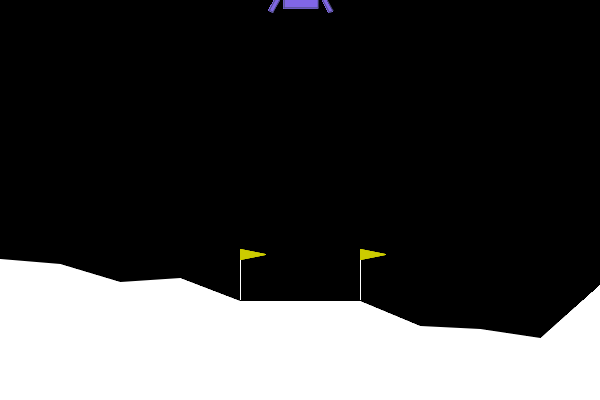

Generating GIF for GA seed 123 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_ga/ga_seed123.gif


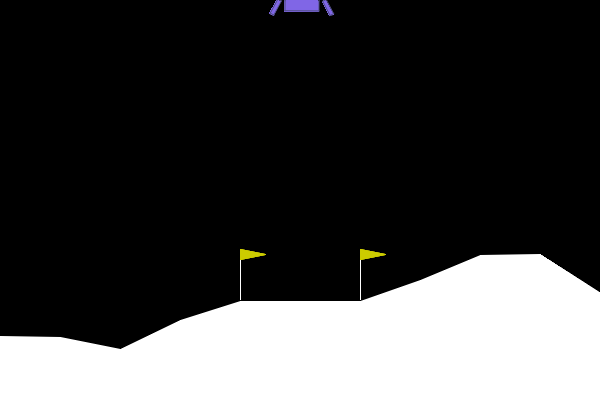

Generating GIF for GA seed 3407 (best genome)...
  Saved: /home/logus/env/iscte/taap_p2/report/outputs_ga/ga_seed3407.gif


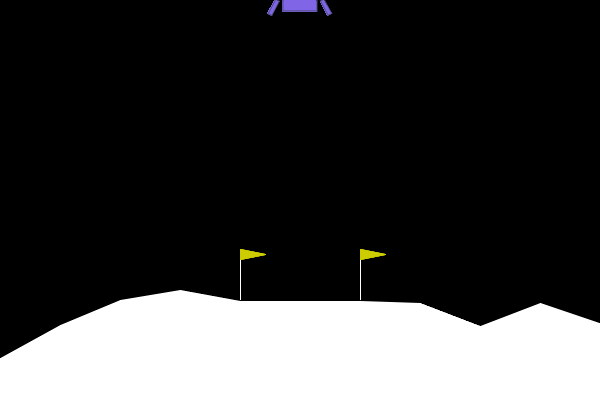

In [26]:
# GIF Visualization (one per seed, best genome)

output_dir = os.path.join(NOTEBOOK_DIR, "outputs_ga")
os.makedirs(output_dir, exist_ok=True)

for seed in SEED_LIST:
    print(f"Generating GIF for GA seed {seed} (best genome)...")

    gif_path = os.path.join(output_dir, f"ga_seed{seed}.gif")
    record_genome_gif(best_genomes[seed], seed, gif_path)

    print(f"  Saved: {gif_path}")
    display(Image(filename=gif_path))

In [27]:
# Hyperparameter Table

params = {
    "input_size": INPUT_SIZE,
    "hidden1_size": HIDDEN1_SIZE,
    "hidden2_size": HIDDEN2_SIZE,
    "output_size": OUTPUT_SIZE,
    "population_size": POPULATION_SIZE,
    "mutation_rate": MUTATION_RATE,
    "generations": GENERATIONS,
    "eval_seeds_per_generation": EVAL_SEEDS_PER_GEN,
    "elitism": 3,
    "parent_selection": "top 20%",
    "crossover": "uniform gene-wise",
    "mutation": "Gaussian (clipped +/-0.1)",
    "activation": "tanh (hidden), linear (output)",
    "max_workers": MAX_WORKERS,
}

rows = [{"Parameter": k, "Value": str(v)} for k, v in params.items()]

print("*** GA Hyperparameters ***")
print(pd.DataFrame(rows).to_string(index=False))

*** GA Hyperparameters ***
                Parameter                          Value
               input_size                              8
             hidden1_size                             10
             hidden2_size                             10
              output_size                              4
          population_size                             50
            mutation_rate                           0.05
              generations                           5000
eval_seeds_per_generation                              3
                  elitism                              3
         parent_selection                        top 20%
                crossover              uniform gene-wise
                 mutation      Gaussian (clipped +/-0.1)
               activation tanh (hidden), linear (output)
              max_workers                             20


---

## Appendix: Experimental Setup

### Environment Details

| Property | Value |
|---|---|
| Environment | `LunarLander-v3` (Gymnasium) |
| Observation Space | `Box(8,)` — continuous 8-dimensional vector |
| Action Space | `Discrete(4)` — do nothing, fire left, fire main, fire right |
| Solved Threshold | Mean reward >= 200 over 100 consecutive episodes |
| Wind | Disabled (`enable_wind=False`) |

**Observation vector:** `[x, y, vx, vy, angle, angular_velocity, left_leg_contact, right_leg_contact]`

**Reward structure:**
- Moving toward the landing pad: positive
- Moving away: negative
- Crash: -100
- Successful landing: +100
- Each leg ground contact: +10
- Firing main engine: -0.3 per frame
- Firing side engine: -0.03 per frame

**Termination rules:**
- **Terminated (success):** The lander comes to rest on the ground with both legs in contact, near-zero velocity
- **Terminated (crash):** The lander body contacts the ground, or the lander moves outside the viewport boundaries
- **Truncated (timeout):** The episode exceeds 1000 timesteps without termination

In [28]:
# System and library versions

print(f"Python: {sys.version.split()[0]}")
print(f"Gymnasium: {gym.__version__}")
print(f"NumPy: {np.__version__}")
print(f"Network: {INPUT_SIZE} -> {HIDDEN1_SIZE} -> {HIDDEN2_SIZE} -> {OUTPUT_SIZE}")
print(f"Activation: tanh (hidden), linear (output)")

Python: 3.12.3
Gymnasium: 1.2.3
NumPy: 2.4.2
Network: 8 -> 10 -> 10 -> 4
Activation: tanh (hidden), linear (output)


---